In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import PMTPosition as PMT
from tqdm import tqdm

In [2]:
GEM_width,  GEM_height = PMT.GetGEMsDim()
GEM_z_dist = PMT.GetGEMsZ()

## Standard configuration of Cameras and PMTs
### Scanned PMT X positions
# DX = -0.83333
# DX = 0                         
DX = 1.66666          
# DX = 4.16666          
# DX = 11.6666665

CAM_pos = np.array([[GEM_width/2, GEM_height/2 + GEM_height/3],
                    [GEM_width/2, GEM_height/2],
                    [GEM_width/2, GEM_height/2 - GEM_height/3]
                   ])

PMT_pos = np.array([[GEM_width/2 - GEM_height/3/2-DX, GEM_height/2 + GEM_height/3+GEM_height/3/2],
                    [GEM_width/2 + GEM_height/3/2+DX, GEM_height/2 + GEM_height/3+GEM_height/3/2],
                    [GEM_width/2 - GEM_height/3/2-DX, GEM_height/2 + GEM_height/3-GEM_height/3/2],
                    [GEM_width/2 + GEM_height/3/2+DX, GEM_height/2 + GEM_height/3-GEM_height/3/2],
                    [GEM_width/2 - GEM_height/3/2-DX, GEM_height/2 - GEM_height/3+GEM_height/3/2],
                    [GEM_width/2 + GEM_height/3/2+DX, GEM_height/2 - GEM_height/3+GEM_height/3/2],
                    [GEM_width/2 - GEM_height/3/2-DX, GEM_height/2 - GEM_height/3-GEM_height/3/2],
                    [GEM_width/2 + GEM_height/3/2+DX, GEM_height/2 - GEM_height/3-GEM_height/3/2],
                   ])

In [3]:
## Generate random points in the whole map and retrieve their distances to the PMTs and respectieve integral seen by each PMT, assuming a 55Fe spot-like

n_events = 500_000
pos  = PMT.GenEventPosition(size = n_events)
ints = PMT.GetIntegrals(PMT.GetR_All(PMT_pos = PMT_pos, Event_pos = pos), energy = 5.9, LY = 8500.0)

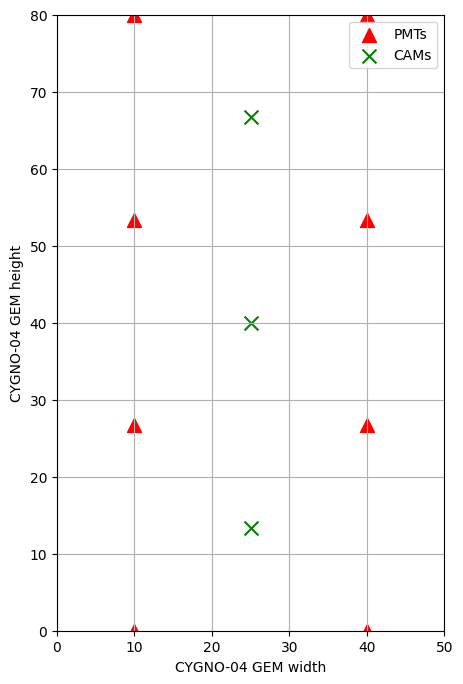

[[ 1.00000067e+01  8.00000000e+01]
 [ 3.99999933e+01  8.00000000e+01]
 [ 1.00000067e+01  5.33333333e+01]
 [ 3.99999933e+01  5.33333333e+01]
 [ 1.00000067e+01  2.66666667e+01]
 [ 3.99999933e+01  2.66666667e+01]
 [ 1.00000067e+01 -1.77635684e-15]
 [ 3.99999933e+01 -1.77635684e-15]]


In [4]:
## Plotting GEM frame

plt.figure(figsize=(5, 8))
#plt.scatter(pos[:, 0], pos[:, 1], color='blue', label=None)
plt.scatter(PMT_pos[:, 0], PMT_pos[:, 1], color='red', label='PMTs', marker='^', s=100)
plt.scatter(CAM_pos[:, 0], CAM_pos[:, 1], color='green', label='CAMs', marker='x', s=100)
plt.xlabel('CYGNO-04 GEM width')
plt.ylabel('CYGNO-04 GEM height')
plt.xlim(0,GEM_width)
plt.ylim(0,GEM_height)
plt.legend()
plt.grid(True)
plt.show()
print(PMT_pos)

In [5]:
## For each simulated point, sum the integral of all PMTs
summed = np.zeros(len(ints[:,0]))
for i in range(len(ints[0, :])):
    summed = summed + ints[:,i]

## Create a binned version of the GEM frame (100*160 bins)
bins = [np.linspace(0., GEM_width,    int(GEM_width)*2+1),
        np.linspace(0., GEM_height,  int(GEM_height)*2+1)]
image = np.zeros((len(bins[0])-1, len(bins[1])-1))

## Limits for 2D histogram, important to fix to visually compare options
plot_max = 0.00115
plot_min = 0.0006

## Variables used to assess the amount of points below a certain percentage of the total Z range
points_below_20 = 0
points_below_30 = 0
points_below_40 = 0
points_below_50 = 0
overall_total = 0

## Creating 2D histogram
for i in tqdm(range(len(image))):
    for j in range(len(image[0])):
        indices = np.where((pos[:,0]>bins[0][i])&(pos[:,0]<=bins[0][i+1])&(pos[:,1]>bins[1][j])&(pos[:,1]<=bins[1][j+1]))
        image[i][j] += np.sum(summed[indices]) / len(summed[indices])

## Calculate remaining variables
for i in tqdm(range(len(image))):
    for j in range(len(image[0])):

        overall_total += image[i][j]
        
        if image[i][j] < ( (plot_max - plot_min)*0.2 + plot_min ):
            points_below_20 += 1
        if image[i][j] < ( (plot_max - plot_min)*0.3 + plot_min ):
            points_below_30 += 1
        if image[i][j] < ( (plot_max - plot_min)*0.4 + plot_min ):
            points_below_40 += 1
        if image[i][j] < ( (plot_max - plot_min)*0.5 + plot_min ):
            points_below_50 += 1

## Normalize and create percentage
points_below_20 /= (len(image)*len(image[0]))
points_below_20 *= 100

points_below_30 /= (len(image)*len(image[0]))
points_below_30 *= 100

points_below_40 /= (len(image)*len(image[0]))
points_below_40 *= 100

points_below_50 /= (len(image)*len(image[0]))
points_below_50 *= 100

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3103.54it/s]


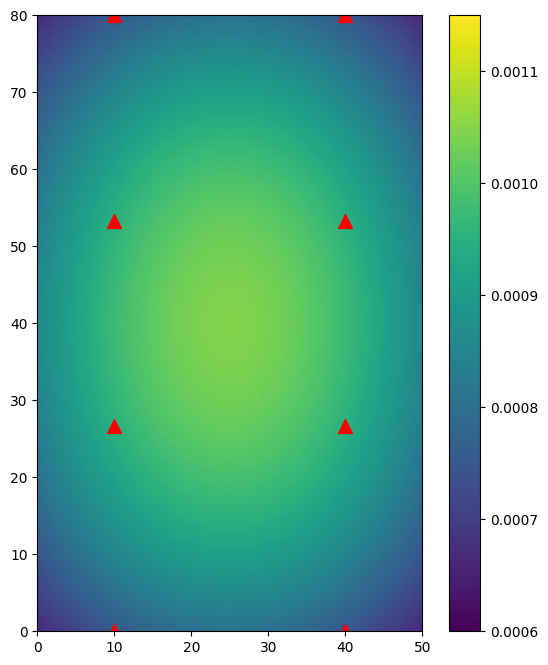

The overall total of this cofiguration is: 14.500161501975866
The amount of points below 20% is 1.15625 %
The amount of points below 30% is 5.9875 %
The amount of points below 40% is 17.306250000000002 %
The amount of points below 50% is 36.30625 %


In [6]:
## Plot 2D histogram and print calculated variables
plt.figure(figsize=(7, 8))
plt.imshow(image.T, extent=[0,50, 0,80], vmin=plot_min, vmax=plot_max)
plt.colorbar()
plt.scatter(PMT_pos[:, 0], PMT_pos[:, 1], color='red', label='PMTs', marker='^', s=100)
plt.show()

print('The overall total of this cofiguration is: {}'.format(overall_total))
print('The amount of points below 20% is {} %'.format(points_below_20))
print('The amount of points below 30% is {} %'.format(points_below_30))
print('The amount of points below 40% is {} %'.format(points_below_40))
print('The amount of points below 50% is {} %'.format(points_below_50))